In [82]:
from numpy.random import seed
seed(1)
import tensorflow


In [83]:
import os
import random
import shutil
import librosa 
import numpy as np
import pandas as pd




import warnings
warnings.filterwarnings("ignore")

In [84]:
files_list = []

for root, dirs, files in os.walk(r"C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\en\clips"):
    for file in files:
        if file.endswith(".mp3") :
            files_list.append(os.path.join(root, file))

# print files_list   
filesToCopy = random.sample(files_list, 400) 

destPath = r"C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio"


# iteraate over all random files and move them
for file in filesToCopy:
    shutil.move(file, destPath)

    Let's see the fake audios...

# 1) Real audio data VS. Cloned audio data

In [85]:
pd.options.display.max_colwidth = 1000

fake_file_list = os.listdir(r'C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\long_version_audio') 
#read them into pandas
fake_df = pd.DataFrame(fake_file_list)
# Renaming the column name to file
fake_df = fake_df.rename(columns={0:'file'})
fake_df['real'] = 0
fake_df.file = [r"C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\long_version_audio\\" + i for i in fake_df.file]
fake_df.head(2)



,file,real
0,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\long_version_audio\\FADG0.wav,0
1,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\long_version_audio\\FAKS0.wav,0


    And the real ones
    

In [86]:
#list the files
real_file_list = os.listdir(r"C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio") 
#read them into pandas
real_df = pd.DataFrame(real_file_list)
# Renaming the column name to file
real_df = real_df.rename(columns={0:'file'})
real_df['real'] = 1
real_df.file = [r"C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio\\" + i for i in real_df.file]
real_df.head(2)

,file,real
0,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio\\common_voice_en_34925888.mp3,1
1,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio\\common_voice_en_34925929.mp3,1


In [87]:
real_df.shape, fake_df.shape

((1600, 2), (336, 2))

In [88]:
df = pd.concat([real_df, fake_df], axis=0)
df.head(2)

,file,real
0,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio\\common_voice_en_34925888.mp3,1
1,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio\\common_voice_en_34925929.mp3,1


In [89]:
df.shape

(1936, 2)

In [90]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,file,real
0,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio\\common_voice_en_36435768.mp3,1
1,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio\\common_voice_en_36380688.mp3,1
2,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio\\common_voice_en_36084810.mp3,1
3,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\long_version_audio\\FLNH0.wav,0
4,C:\Users\abedq\Desktop\Apziva\Apziva\P6\New folder\CommonVoice Dataset\cv-corpus-12.0-delta-2022-12-07\real_audio\\common_voice_en_35971016.mp3,1


    Split the files into train, test and val.

In [91]:
from sklearn.model_selection import train_test_split
X = df[['file']]
y = df.real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)


print(f"X_train length is: {len(X_train)}, y_train length is: {len(y_train)}")
print(f"X_test length is: {len(X_test)}, y_test length is: {len(y_test)}")
print(f"X_val length is: {len(X_val)}, y_val length is: {len(y_val)}")

X_train length is: 1567, y_train length is: 1567
X_test length is: 194, y_test length is: 194
X_val length is: 175, y_val length is: 175


To extract the audio features, we will use `extract_features` function...

In [92]:
def extract_features(files):
    """
    Return mfccs, chroma, mel, contrast, and tonnetz for each audio file.
    """
    df = {'mfccs': [], 'chroma': [], 'mel': [], 'contrast': [], 'tonnetz': []}
    for file_name in files:
        # Loads the audio file as a floating point time series and assigns the default sample rate
        # Sample rate is set to 22050 by default
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        df['mfccs'].append(mfccs)
        # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
        stft = np.abs(librosa.stft(X))
        # Computes a chromagram from a waveform or power spectrogram.
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        df['chroma'].append(chroma)
        # Computes a mel-scaled spectrogram.
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
        df['mel'].append(mel)
        # Computes spectral contrast
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
        df['contrast'].append(contrast)
        # Computes the tonal centroid features (tonnetz)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
        df['tonnetz'].append(tonnetz)
    return df


In [93]:
val_features = extract_features(X_val.file)
train_features = extract_features(X_train.file)
test_features = extract_features(X_test.file)

In [94]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

    Let's scale all of the features and concatenate them into an array for each audio file by using `concat_features` function.

In [95]:
def concat_features(features):
    features_list = []
    for i in range(0, len(features['mfccs'])):
      features_list.append(np.concatenate((
          scalar.fit_transform((features['mfccs'][i]).reshape(-1, 1)),
          scalar.fit_transform((features['chroma'][i]).reshape(-1, 1)), 
          scalar.fit_transform((features['mel'][i]).reshape(-1, 1)), 
          scalar.fit_transform((features['contrast'][i]).reshape(-1, 1)),
          scalar.fit_transform((features['tonnetz'][i]).reshape(-1, 1))), axis=0))
    return np.array(features_list).reshape(len(features['mfccs']), 193)

In [96]:
X_val_data = concat_features(val_features)
X_train_data = concat_features(train_features)
X_test_data = concat_features(test_features)

In [97]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [99]:
import tensorflow as tf

In [100]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=50, input_shape=(193,), activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

model_1.compile(loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()], optimizer='adam')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [101]:
hist_1 = model_1.fit(X_train_data, y_train, validation_data=(X_val_data, y_val), epochs=2000, callbacks=[early_stop])

Train on 1567 samples, validate on 175 samples
Epoch 1/2000
1567/1567 [==============================] - 0s 188us/sample - loss: 0.3671 - auc_4: 0.8458 - val_loss: 0.1449 - val_auc_4: 0.9904
Epoch 2/2000
1567/1567 [==============================] - 0s 63us/sample - loss: 0.1010 - auc_4: 0.9921 - val_loss: 0.0680 - val_auc_4: 0.9981
Epoch 3/2000
1567/1567 [==============================] - 0s 62us/sample - loss: 0.0572 - auc_4: 0.9976 - val_loss: 0.0501 - val_auc_4: 0.9996
Epoch 4/2000
1567/1567 [==============================] - 0s 61us/sample - loss: 0.0418 - auc_4: 0.9985 - val_loss: 0.0331 - val_auc_4: 1.0000
Epoch 5/2000
1567/1567 [==============================] - 0s 59us/sample - loss: 0.0319 - auc_4: 0.9992 - val_loss: 0.0231 - val_auc_4: 1.0000
Epoch 6/2000
1567/1567 [==============================] - 0s 61us/sample - loss: 0.0228 - auc_4: 0.9996 - val_loss: 0.0175 - val_auc_4: 1.0000
Epoch 7/2000
1567/1567 [==============================] - 0s 59us/sample - loss: 0.0176 - auc_

In [105]:
!pip install matplotlib

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


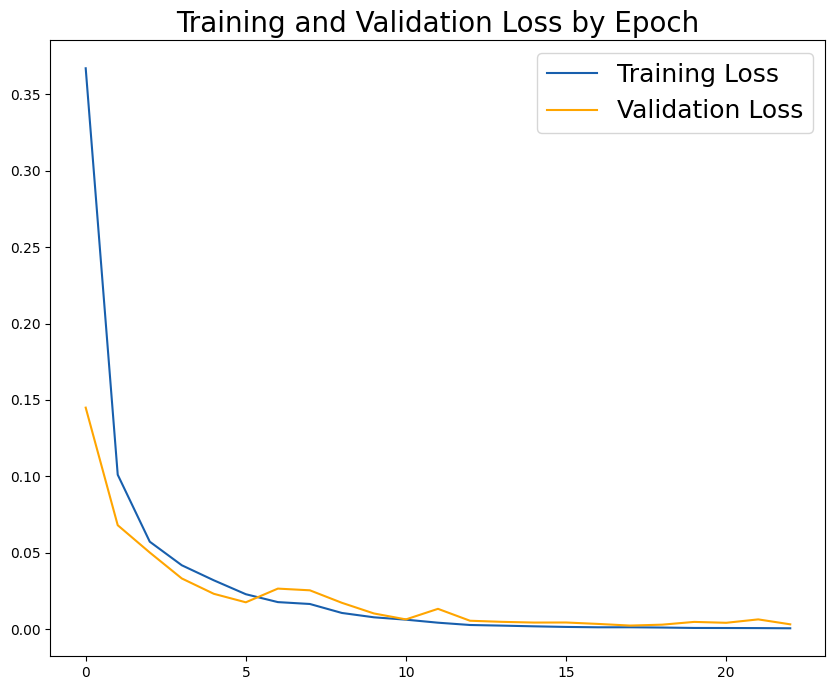

In [107]:
plt.figure(figsize=(10, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(hist_1.history['loss'], label='Training Loss', color='#185fad')
plt.plot(hist_1.history['val_loss'], label='Validation Loss', color='orange')
# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 20)
plt.legend(fontsize = 18);

194/194 [==============================] - 0s 52us/sample - loss: 0.0715 - auc_4: 0.9854
test evaluation [0.07149673828353491, 0.98536754]


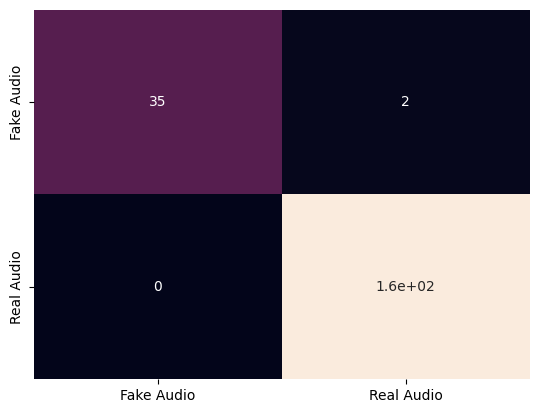

In [111]:
print('test evaluation', model_1.evaluate(X_test_data, y_test))
cm = confusion_matrix(y_test, y_pred=np.round(model_1.predict(X_test_data)))
ax = sns.heatmap(cm, annot=True, cbar=False)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Fake Audio', 'Real Audio'])
ax.yaxis.set_ticklabels(['Fake Audio', 'Real Audio'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [109]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ...

y_pred = np.round(model_1.predict(X_test_data))
cm = confusion_matrix(y_test, y_pred)

# ...

# Display the visualization of the Confusion Matrix.
plt.show()


In [ ]:
predictions_ = X_test.reset_index(drop=True)
predictions_['y_true'] = y_test
pred = np.round(model_1.predict(X_test_data)).reshape(74,)
predictions_['y_pred'] = pred
predictions_[predictions_.y_true != predictions_.y_pred]

---

In [66]:
Audio(predictions_.file[2], autoplay=True)

In [67]:
Audio(predictions_.file[16], autoplay=True)

In [68]:
Audio(predictions_.file[18], autoplay=True)

In [69]:
Audio(predictions_.file[22], autoplay=True)

In [70]:
Audio(predictions_.file[29], autoplay=True)

In [71]:
Audio(predictions_.file[31], autoplay=True)